In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [2]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "CIFAR-10"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

In [3]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

### Load CIFAR-10 data

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Image scaling to 0-1
# train_images = train_images / 255.0
# test_images = test_images / 255.0

if train_labels.ndim == 2:
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()


total_data = f"Total Data on RAM -{(train_images.size + test_images.size) / 1024**2 : .2f} MB"
total_data

'Total Data on RAM - 175.78 MB'

### Displaying the first image in the training set

In [6]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

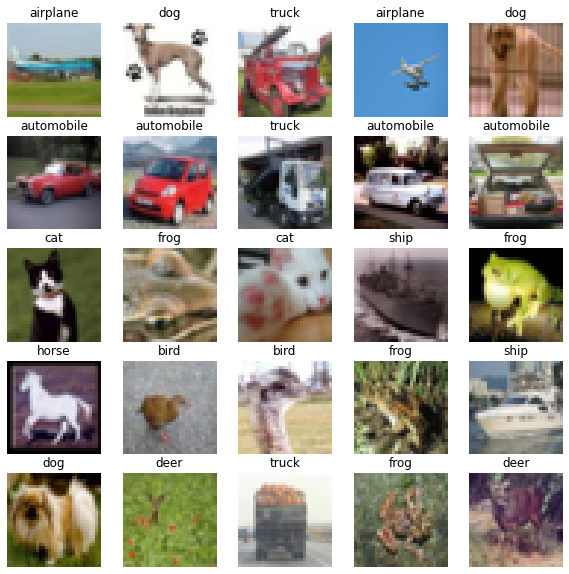

In [7]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, give_class_name(labels))

### Preprocessing the data

In [8]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## MODELS

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


In [10]:
MODELS_PATH = ROOT_DIR / "models"
INPUT_SHAPE = train_images.shape[1:]
models_performance = {}
TRAIN_MODELS = True
# TRAIN_MODELS = False

In [11]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
        
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    if labels:
        cr = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
        
    plt.show()
    
def get_model_performance(y_true, y_pred):
    accuracy = accuracy_score(test_labels, test_labels_pred)
    f1_scr = f1_score(test_labels, test_labels_pred, average='weighted')
    precision_scr = precision_score(test_labels, test_labels_pred, average='weighted')
    recall_scr = recall_score(test_labels, test_labels_pred, average='weighted')
    
    performance = {
        "Accuracy": accuracy,
        "F1 Score": f1_scr,
        "Precision": precision_scr,
        "Recall": recall_scr
    }
    
    return performance

### Simple Sequential Model

#### init

In [12]:
from tensorflow.keras.models import Sequential

model_name = "simple_sequential"

def simple_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [13]:
model = simple_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0

2022-06-15 10:03:13.609024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 10:03:13.628460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 10:03:13.628607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 10:03:13.629047: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

#### Train

In [14]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [15]:
train_model = not (os.path.exists(f"{MODELS_PATH}/{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                        epochs=30, batch_size=64,
                        validation_split=0.2, callbacks=callbacks)

Epoch 1/30


2022-06-15 10:03:15.176500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-15 10:03:15.760385: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-15 10:03:15.760879: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-15 10:03:15.760909: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-06-15 10:03:15.761380: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-15 10:03:15.761432: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-15 10:03:16.317502: I tensorflow/stream_executor/cuda/c

620/625 [============================>.] - ETA: 0s - loss: 1.5945 - accuracy: 0.4414
Epoch 1: val_accuracy improved from -inf to 0.47840, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 4s 2ms/step - loss: 1.5919 - accuracy: 0.4425 - val_loss: 1.4581 - val_accuracy: 0.4784
Epoch 2/30
620/625 [============================>.] - ETA: 0s - loss: 1.1572 - accuracy: 0.5994
Epoch 2: val_accuracy improved from 0.47840 to 0.59610, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 1s 2ms/step - loss: 1.1564 - accuracy: 0.5998 - val_loss: 1.1513 - val_accuracy: 0.5961
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 0.9544 - accuracy: 0.6708
Epoch 3: val_accuracy improved from 0.59610 to 0.62610, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============

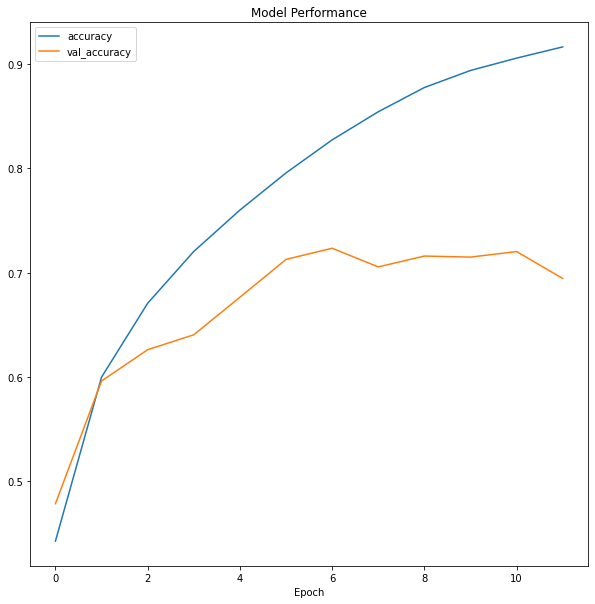

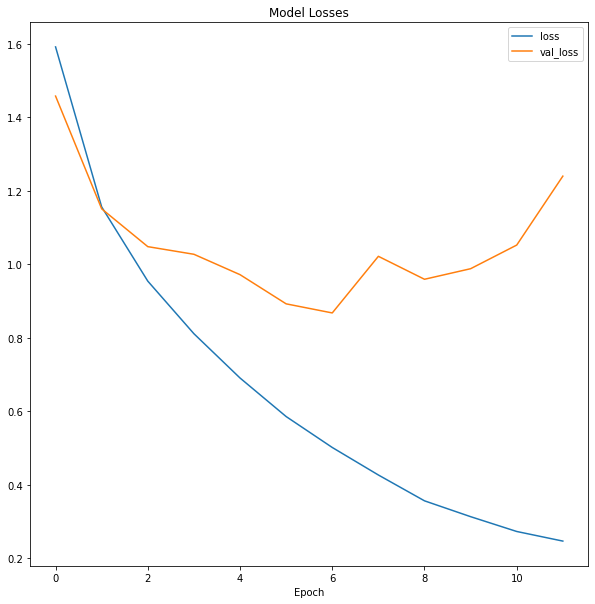

In [16]:
if train_model:
    plot_model_performance(history)

In [17]:
if train_model:
    model.evaluate(test_images, y_test)

313/313 [==============================] - 0s 836us/step - loss: 1.2815 - accuracy: 0.6903


#### Testing and Evaluating

In [18]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

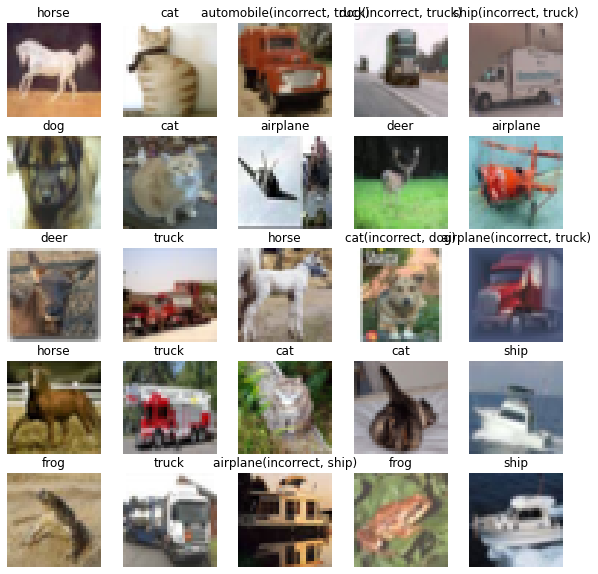

In [19]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


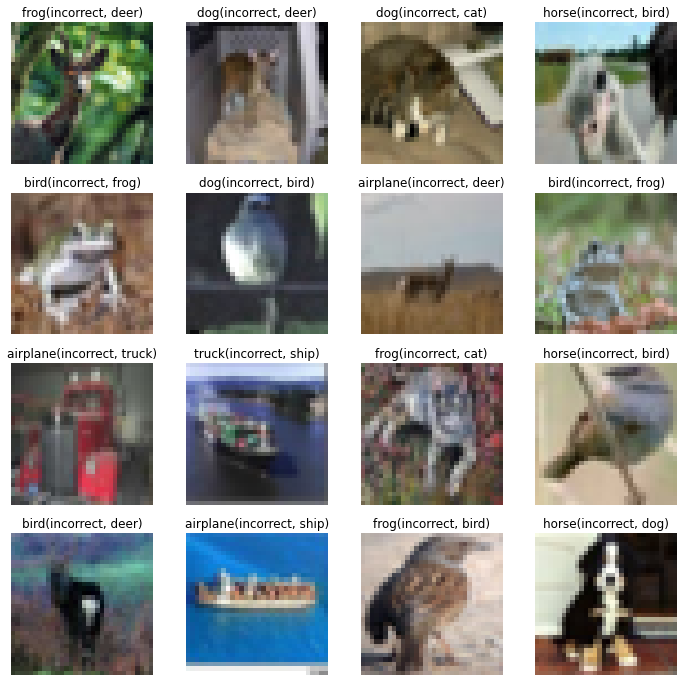

In [20]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.715


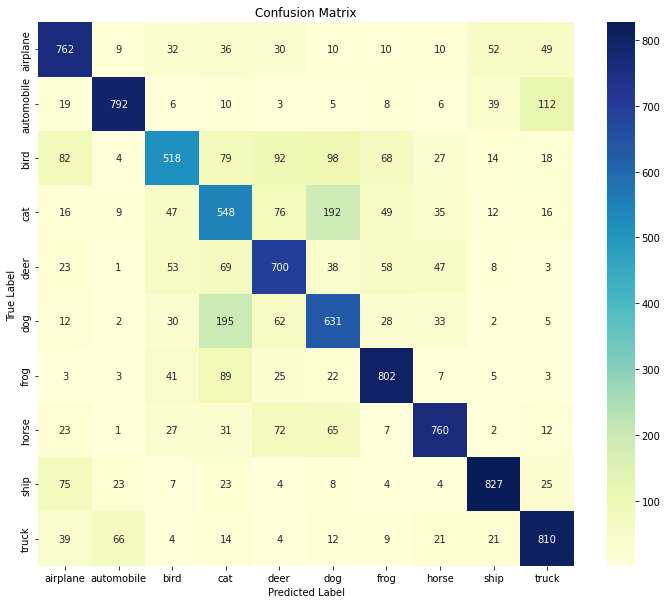

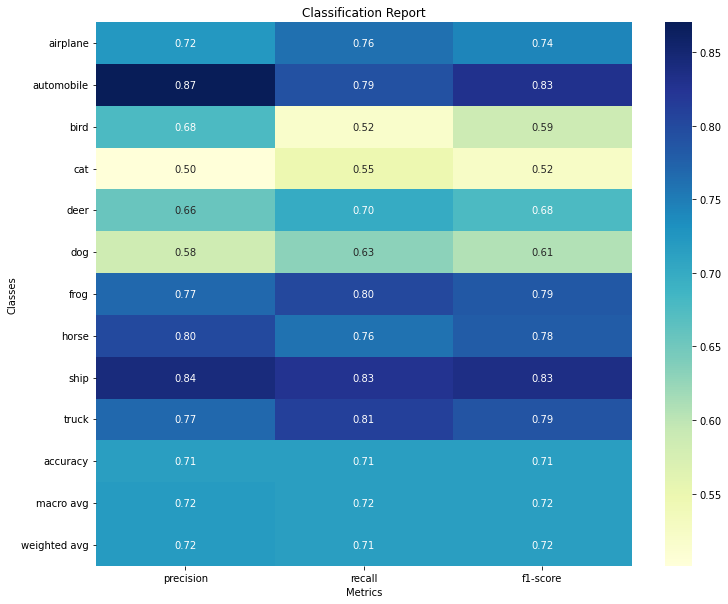

In [21]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

### Deeper Sequential Model

#### init

In [22]:
from tensorflow.keras.models import Sequential

model_name = "deeper_sequential"

def deeper_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [23]:
model = deeper_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)       

#### Train

In [24]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [25]:
train_model = not (os.path.exists(f"{MODELS_PATH}/{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/30
624/625 [============================>.] - ETA: 0s - loss: 1.8854 - accuracy: 0.3078
Epoch 1: val_accuracy improved from -inf to 0.43810, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/deeper_sequential.h5
625/625 [==============================] - 3s 5ms/step - loss: 1.8849 - accuracy: 0.3079 - val_loss: 1.5007 - val_accuracy: 0.4381
Epoch 2/30
617/625 [============================>.] - ETA: 0s - loss: 1.4412 - accuracy: 0.4827
Epoch 2: val_accuracy improved from 0.43810 to 0.56340, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/deeper_sequential.h5
625/625 [==============================] - 3s 4ms/step - loss: 1.4412 - accuracy: 0.4830 - val_loss: 1.2715 - val_accuracy: 0.5634
Epoch 3/30
622/625 [============================>.] - ETA: 0s - loss: 1.2272 - accuracy: 0.5761
Epoch 3: val_accuracy improved from 0.56340 to 0.59910, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/deeper_sequential.h5
625/625 [===

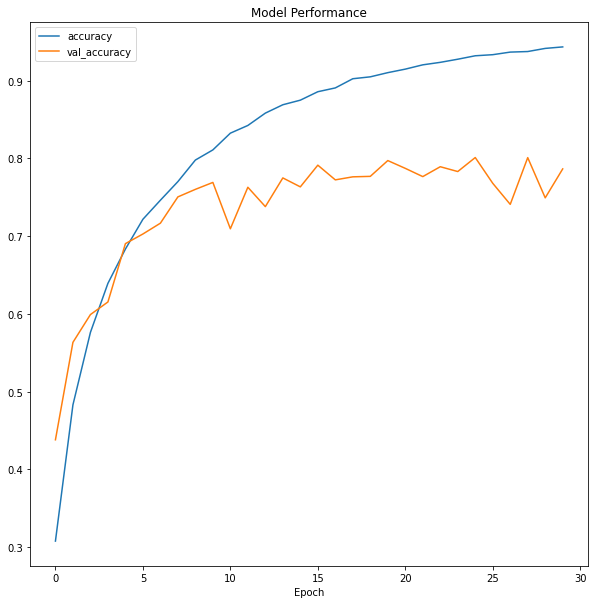

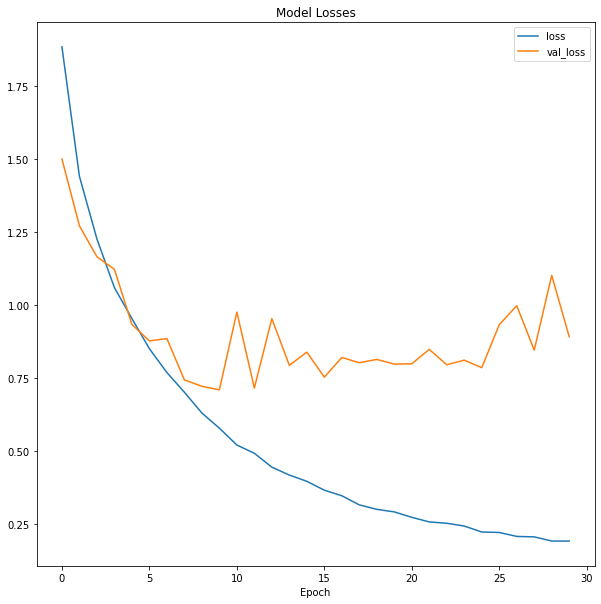

In [26]:
if train_model:
    plot_model_performance(history)

In [27]:
if train_model:
    model.evaluate(test_images, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.8945 - accuracy: 0.7800


#### Testing and Evaluating

In [28]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

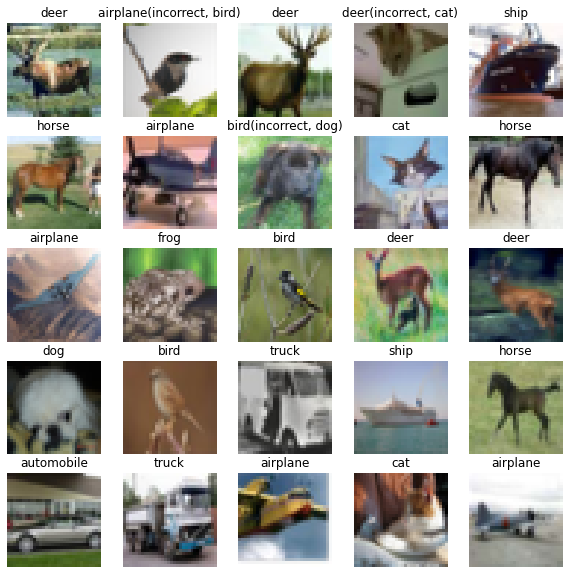

In [29]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


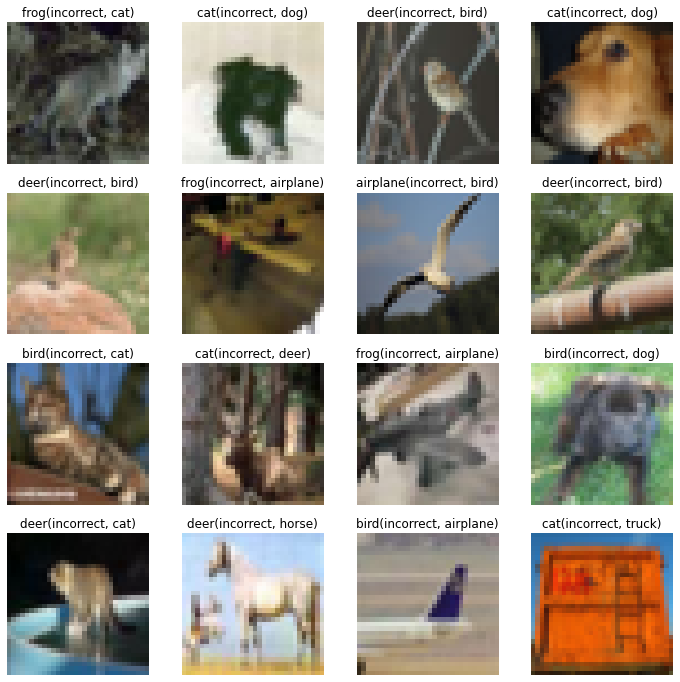

In [30]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.7947


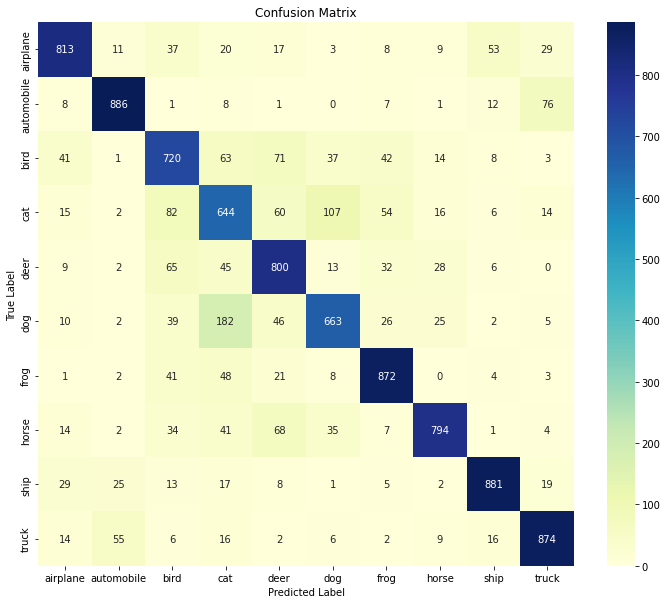

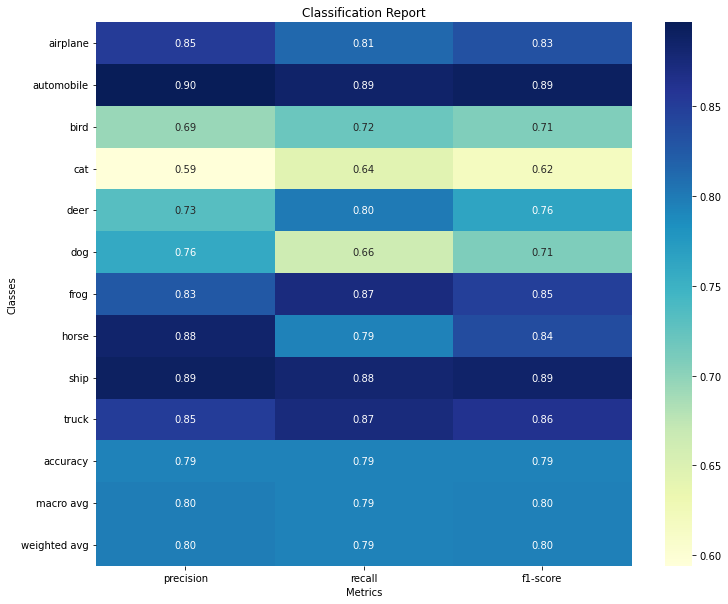

In [31]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

### VGG-Like Model

#### init

In [32]:
from tensorflow.keras.models import Model

model_name = "complex_sequential"   # complex_sequential - Inspired by VGG16's blocks

# def block(input_tensor, filters, kernel_size, strides=(1, 1), activation='relu', padding='same'):
#     x = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation)(input_tensor)
#     x = BatchNormalization()(x)
#     return x

def block(input_tensor, filters: int, convolutional_layers: int, kernel_size: int = 3, activation='relu', padding='same', poll_size: int = 2):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(input_tensor)
    for _ in range(convolutional_layers - 1):
        x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
        
    x = MaxPooling2D(pool_size=poll_size)(x)
    x = BatchNormalization()(x)
    
    return x
    

def complex_sequential_model(input_shape, num_classes):
    input_scale = 1./255

    inputs = Input(shape=input_shape)
    x = Rescaling(input_scale)(inputs)
    
    x = block(x, 64, 2, activation='relu', padding='same')      # block 1(2) - 28x28x3 -> 14x14x64
    x = block(x, 128, 2, activation='relu', padding='same')     # block 2(2) - 14x14x64 -> 7x7x128
    x = block(x, 256, 2, activation='relu', padding='same')     # block 3(2) - 7x7x128 -> 4x4x256
    
    x = Flatten()(x)                                            # flatten - 4x4x256 -> 4096
    
    x = Dense(256, activation='relu')(x)                        # dense(1) - 4096 -> 512
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu')(x)                        # dense(1) - 512 -> 128
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32, activation='relu')(x)                        # dense(1) - 128 -> 32
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)       # dense(1) - 32 -> 10
    
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [33]:
model = complex_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                             

#### Train

In [34]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 8))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check, lrd]

In [35]:
train_model = not (os.path.exists(f"{MODELS_PATH}/{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=40, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.3924
Epoch 1: val_accuracy improved from -inf to 0.51930, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/complex_sequential.h5
625/625 [==============================] - 6s 9ms/step - loss: 1.7179 - accuracy: 0.3924 - val_loss: 1.3078 - val_accuracy: 0.5193 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - ETA: 0s - loss: 1.1468 - accuracy: 0.6059
Epoch 2: val_accuracy improved from 0.51930 to 0.64960, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/complex_sequential.h5
625/625 [==============================] - 5s 9ms/step - loss: 1.1468 - accuracy: 0.6059 - val_loss: 1.0231 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 3/40
620/625 [============================>.] - ETA: 0s - loss: 0.9296 - accuracy: 0.6928
Epoch 3: val_accuracy improved from 0.64960 to 0.65120, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/compl

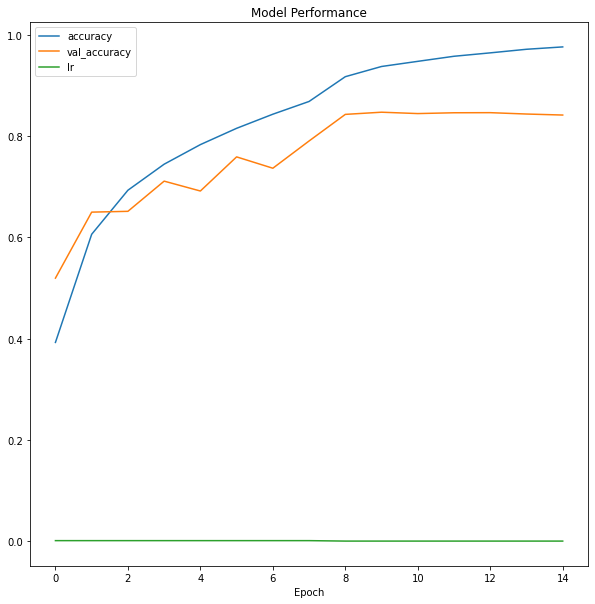

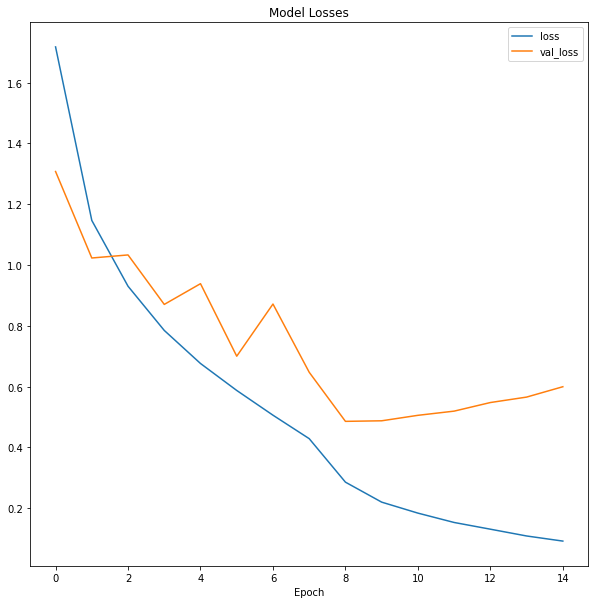

In [36]:
if train_model:
    plot_model_performance(history)

In [37]:
if train_model:
    model.evaluate(test_images, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.6336 - accuracy: 0.8363


#### Testing and Evaluating

In [38]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

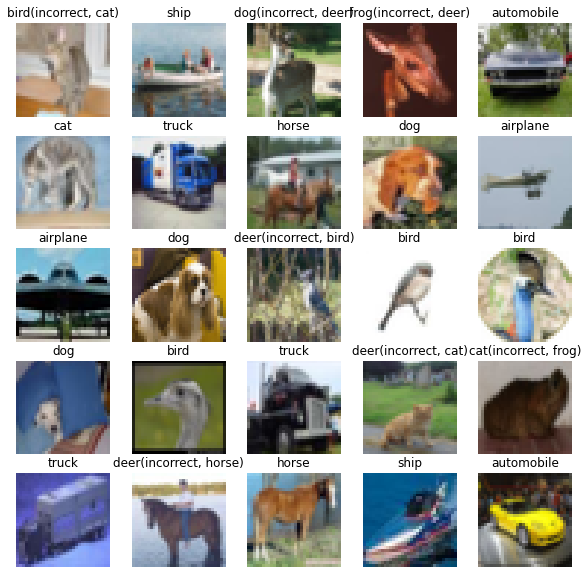

In [39]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


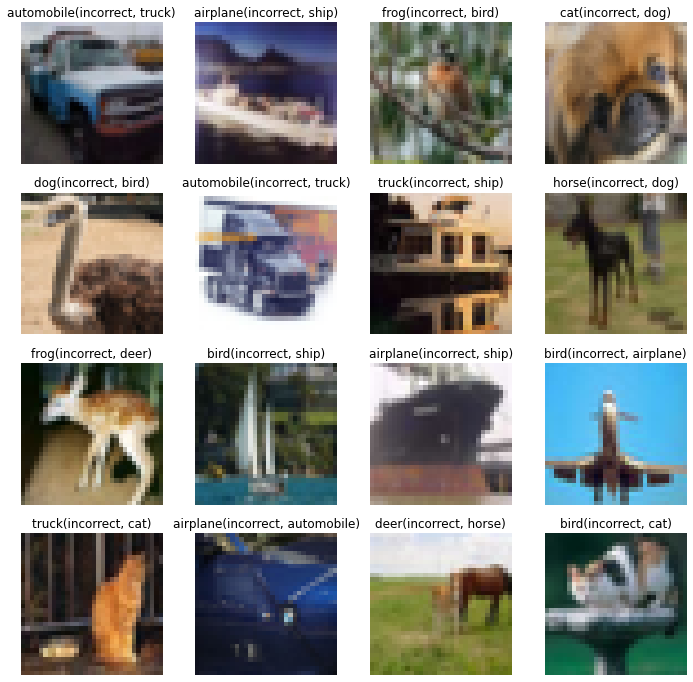

In [40]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.8405


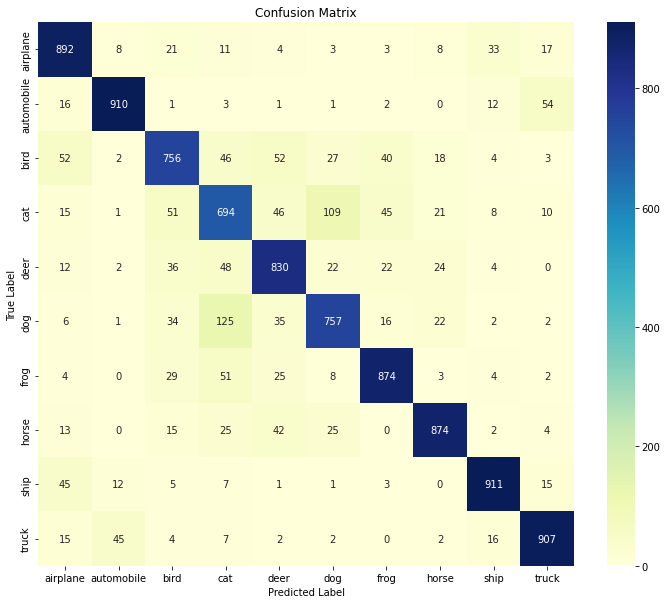

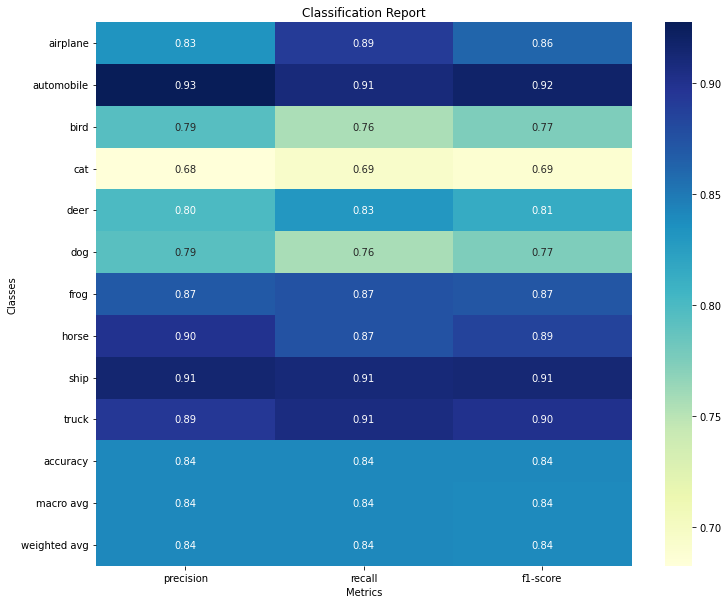

In [41]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

### Resnet-Like Model

#### init

In [42]:
from tensorflow.keras.models import Model
from typing import Union

list_or_int = Union[int, list]

model_name = "Residual_blocks_model"   # complex_sequential - Inspired by Resnet Model

def get_filters(filters: list_or_int) -> tuple[int, int, int]:
    if type(filters) == list:
        if len(filters) != 3:
            raise ValueError("filters must be a list of 3 integers")
        return filters
    else:
        return filters, filters, filters

def identity_block(input_tensor, filters: int, kernel_size: int = 3, activation='relu'):
    """
    Arguments:
    input_tensor -- input tensor of shape (batch_size, n_rows, n_cols, n_channels)
    filters: int -- number of filters in the convolution layer

    kernel_size: int(3) -- size of the kernel
    activation: str('relu') -- activation function
    poll_size: int(2) -- size of the pooling layer
    """

    F1, F2, F3 = get_filters(filters)

    # 1st component
    x = Conv2D(F1, (1,1), padding="valid")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # 2nd component
    x = Conv2D(F2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # 3rd component
    x = Conv2D(F3, (1,1), padding="valid")(x)
    x = BatchNormalization()(x)

    # final component
    x = Add()([x, input_tensor])
    x = Activation(activation)(x)

    return x


def convolutional_block(input_tensor, filters: int, kernel_size: int = 3, activation='relu', stride: int=2):
    """
    Arguments:
    input_tensor -- input tensor of shape (batch_size, n_rows, n_cols, n_channels)
    filters: int -- number of filters in the convolution layer

    kernel_size: int(3) -- size of the kernel
    activation: str('relu') -- activation function
    poll_size: int(2) -- size of the pooling layer
    """

    F1, F2, F3 = get_filters(filters)

    # 1st component
    x = Conv2D(F1, (1, 1), strides=stride, padding="valid")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # 2nd component
    x = Conv2D(F2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # 3rd component
    x = Conv2D(F3, (1, 1), padding="valid")(x)
    x = BatchNormalization()(x)
    
    # input_tensor component
    x_ = Conv2D(F3, (1, 1), strides=stride, padding="valid")(input_tensor)
    x_ = BatchNormalization()(x_)
    
    # final component (joining the input_tensor_component and 3rd_component)
    x = Add()([x, x_])
    x = Activation(activation)(x)
    
    return x


def residual_blocks_model(input_shape, num_classes):
    input_scale = 1./255

    inputs = Input(shape=input_shape)
    x = Rescaling(input_scale)(inputs)
    # Convolutional layers
    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)           # n x n x 3 -> n x n x 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)                               # n x n x 64 -> (n/2) x (n/2) x 64
    # Block 2
    x = convolutional_block(x, [64, 64, 256], kernel_size=3)            # (n/2) x (n/2) x 64 -> (n/4) x (n/4) x 256
    x = identity_block(x, [64, 64, 256], kernel_size=3)                 # (n/4) x (n/4) x 256 -> (n/4) x (n/4) x 256
    x = identity_block(x, [64, 64, 256], kernel_size=3)                 # (n/4) x (n/4) x 256 -> (n/4) x (n/4) x 256
    # Block 3
    x = convolutional_block(x, [128, 128, 512], kernel_size=3, stride=2) # (n/4) x (n/4) x 256 -> (n/8) x (n/8) x 512
    x = identity_block(x, [128, 128, 512], kernel_size=3)               # (n/8) x (n/8) x 512 -> (n/8) x (n/8) x 512
    x = identity_block(x, [128, 128, 512], kernel_size=3)               # (n/8) x (n/8) x 512 -> (n/8) x (n/8) x 512
    # Final block
    x = MaxPooling2D()(x)                                               # (n/4) x (n/4) x 256 -> (n/8) x (n/8) x 256
    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    #output layer
    output_layer = Dense(num_classes, activation='softmax')(x)
    # create model
    model = Model(inputs=inputs, outputs=output_layer, name=model_name)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [43]:
model = residual_blocks_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "Residual_blocks_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 64)   1792        ['rescaling_3[0][0]']            
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                

#### Train

In [44]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=6, mode='max')
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# learning rate scheduler
def get_lr(epoch):
    lr_ = 1e-3
    k = 0.1
    lr = lr_ * np.exp(-k * epoch)
    return lr

lrd = LearningRateScheduler(lambda epoch: get_lr(epoch))

callbacks = [es, mdl_check]
callbacks.append(lrd)

In [45]:
train_model = not (os.path.exists(f"{MODELS_PATH}/{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=40, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/40
620/625 [============================>.] - ETA: 0s - loss: 1.7040 - accuracy: 0.3903
Epoch 1: val_accuracy improved from -inf to 0.48130, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/Residual_blocks_model.h5
625/625 [==============================] - 8s 11ms/step - loss: 1.7011 - accuracy: 0.3916 - val_loss: 1.4330 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 2/40
624/625 [============================>.] - ETA: 0s - loss: 1.2620 - accuracy: 0.5573
Epoch 2: val_accuracy improved from 0.48130 to 0.54300, saving model to /home/vineet/.personal/code/Hello-CNN/CIFAR-10/models/Residual_blocks_model.h5
625/625 [==============================] - 7s 11ms/step - loss: 1.2617 - accuracy: 0.5576 - val_loss: 1.2845 - val_accuracy: 0.5430 - lr: 9.0484e-04
Epoch 3/40
620/625 [============================>.] - ETA: 0s - loss: 1.0626 - accuracy: 0.6368
Epoch 3: val_accuracy did not improve from 0.54300
625/625 [==============================] - 6s 10ms/step - loss: 1.06

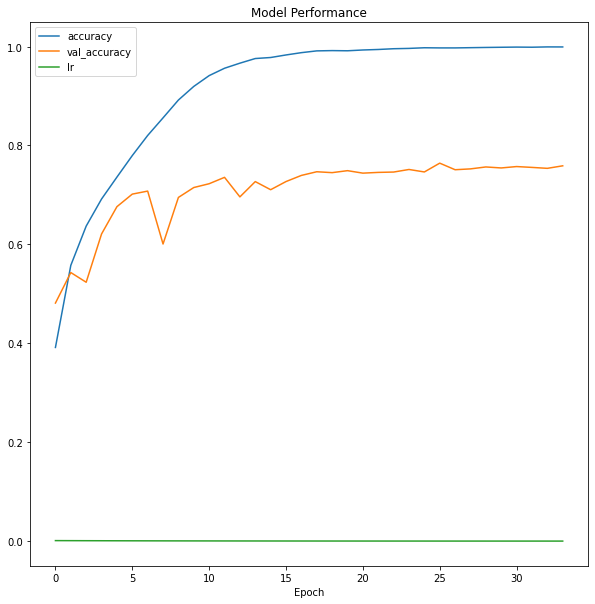

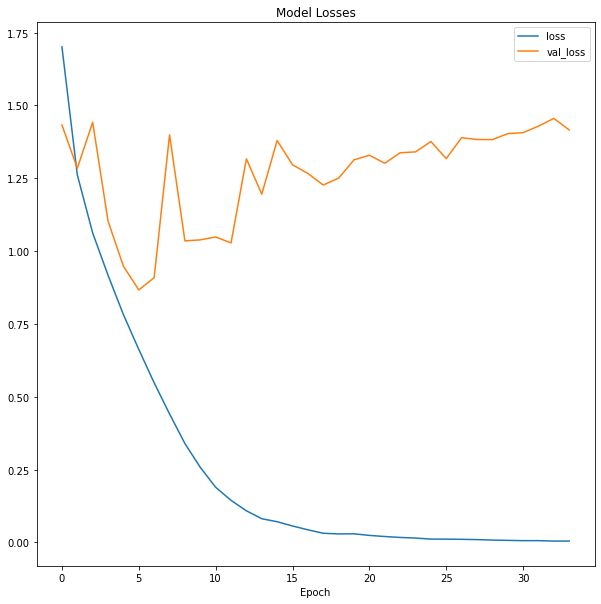

In [46]:
if train_model:
    plot_model_performance(history)

In [47]:
if train_model:
    model.evaluate(test_images, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5061 - accuracy: 0.7500


#### Testing and Evaluating

In [48]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

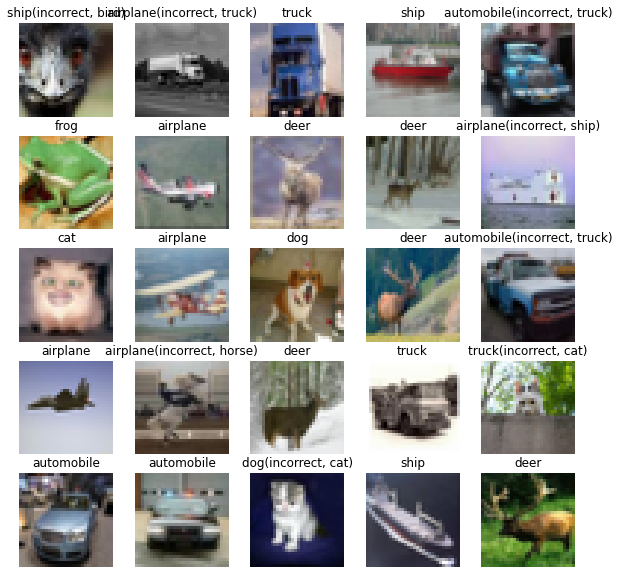

In [49]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


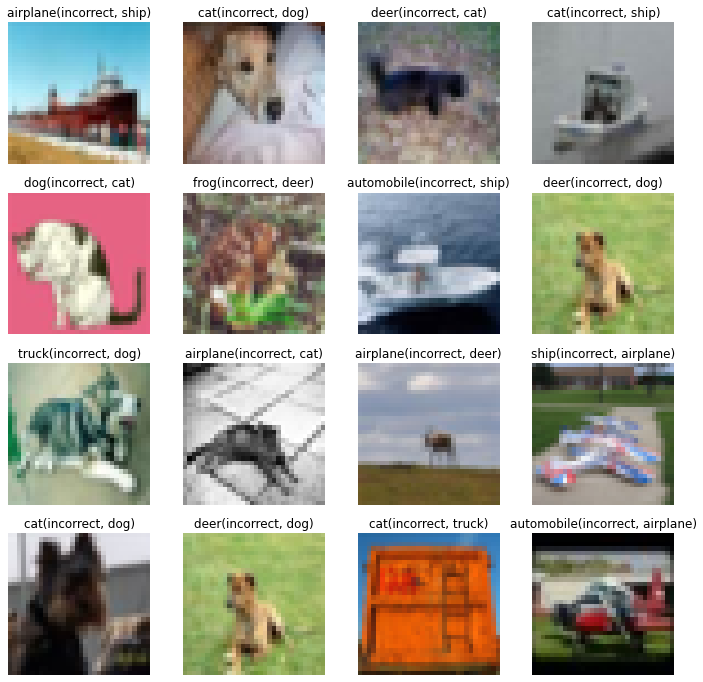

In [50]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.7428


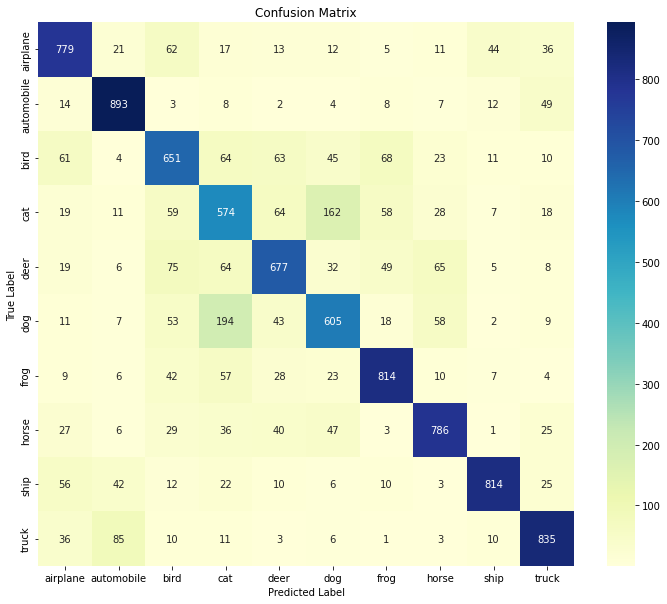

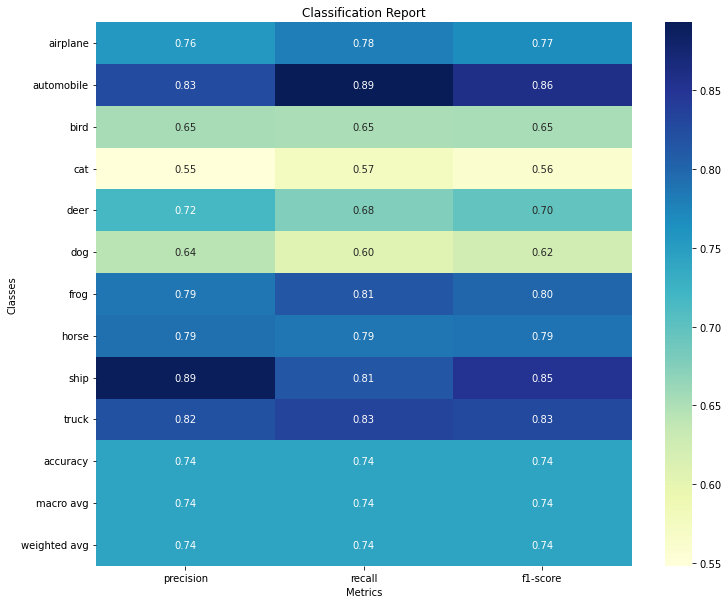

In [51]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

## Results

In [61]:
models_performance_df = pd.DataFrame(models_performance).T.sort_values(by="F1 Score", ascending=False)

models_performance_df

,Accuracy,F1 Score,Precision,Recall
complex_sequential,0.8405,0.840400,0.840804,0.8405
deeper_sequential,0.7947,0.795371,0.797996,0.7947
Residual_blocks_model,0.7428,0.742533,0.743266,0.7428
simple_sequential,0.7150,0.715328,0.719080,0.7150


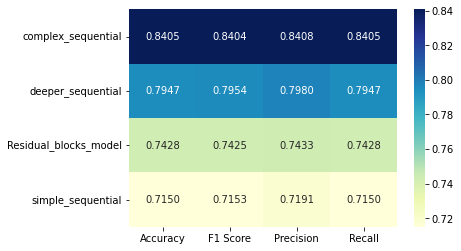

In [62]:
# plot on heatmap
sns.heatmap(models_performance_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.show()